In [1]:
import tensorflow as tf                  # TensorFlow

import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

2024-03-15 17:40:30.392157: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(2115, 22, 1000)


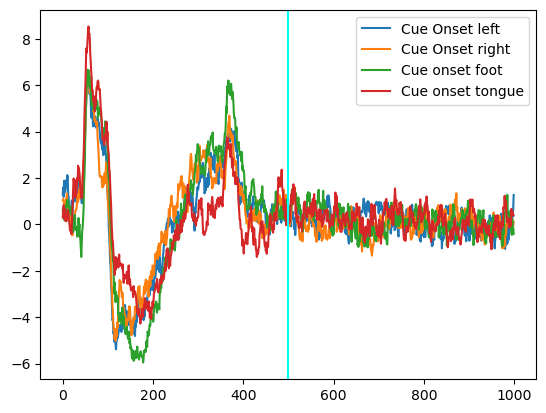

In [2]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("project/X_test.npy")
y_test = np.load("project/y_test.npy")
person_train_valid = np.load("project/person_train_valid.npy")
X_train_valid = np.load("project/X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("project/y_train_valid.npy")
person_test = np.load("project/person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:]


class_0_ind = np.where(y_train_valid == 0)
ch_data_class_0 = ch_data[class_0_ind]
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0)


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])






In [3]:
def train_data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:400]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y


def test_data_prep(X):
    
    total_X = None
    
    
    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:400]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)
    
    
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)
    
    return total_X




In [4]:
## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 400, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)


## Preprocessing the dataset

X_train_prep, y_train_prep = train_data_prep(x_train,y_train,2,2,True)
X_valid_prep = test_data_prep(x_valid) 
X_test_prep = test_data_prep(X_test) 

print('\n')
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train_prep, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = X_train_prep.reshape(X_train_prep.shape[0], X_train_prep.shape[1], X_train_prep.shape[2], 1)
x_valid = X_valid_prep.reshape(X_valid_prep.shape[0], X_valid_prep.shape[1], X_valid_prep.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

print('\n')


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)


Shape of training set: (1715, 22, 1000)
Shape of validation set: (400, 22, 1000)
Shape of training labels: (1715,)
Shape of validation labels: (400,)
Shape of X after trimming: (1715, 22, 400)
Shape of X after maxpooling: (1715, 22, 200)
Shape of X after averaging+noise and concatenating: (3430, 22, 200)
Shape of X after subsampling and concatenating: (6860, 22, 200)
Shape of Y: (6860,)
Shape of X after trimming: (400, 22, 400)
Shape of X after maxpooling: (400, 22, 200)
Shape of X after trimming: (443, 22, 400)
Shape of X after maxpooling: (443, 22, 200)


Shape of training labels after categorical conversion: (6860, 4)
Shape of validation labels after categorical conversion: (400, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (6860, 22, 200, 1)
Shape of validation set after adding width info: (400, 22, 200, 1)
Shape of test set after adding width info: (443, 22, 200, 1)


Shape of training set after dimension reshaping: 

In [25]:
# Building the CNN model using sequential class
hybrid_cnn_lstm_model = Sequential()

# Conv. block 1
hybrid_cnn_lstm_model.add(Conv2D(filters=25, kernel_size=(5,5), padding='same', activation='elu',\
                                 input_shape=(200,1,22)))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 2
hybrid_cnn_lstm_model.add(Conv2D(filters=50, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 3
hybrid_cnn_lstm_model.add(Conv2D(filters=100, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# Conv. block 4
hybrid_cnn_lstm_model.add(Conv2D(filters=200, kernel_size=(5,5), padding='same', activation='elu'))
hybrid_cnn_lstm_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
hybrid_cnn_lstm_model.add(BatchNormalization())
hybrid_cnn_lstm_model.add(Dropout(0.6))

# FC+LSTM layers
hybrid_cnn_lstm_model.add(Flatten()) # Adding a flattening operation to the output of CNN block
hybrid_cnn_lstm_model.add(Dense((40))) # FC layer with 100 units
# hybrid_cnn_lstm_model.add(Dropout(0.2))
hybrid_cnn_lstm_model.add(Reshape((40,1))) # Reshape my output of FC layer so that it's compatible
hybrid_cnn_lstm_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False))


# Output layer with Softmax activation 
hybrid_cnn_lstm_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
hybrid_cnn_lstm_model.summary()




Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 200, 1, 25)        13775     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 67, 1, 25)         0         
 ng2D)                                                           
                                                                 
 batch_normalization_15 (Ba  (None, 67, 1, 25)         100       
 tchNormalization)                                               
                                                                 
 dropout_17 (Dropout)        (None, 67, 1, 25)         0         
                                                                 
 conv2d_16 (Conv2D)          (None, 67, 1, 50)         31300     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 23, 1, 50)        

In [19]:
# Model parameters
learning_rate = 1e-3
epochs = 200
hybrid_cnn_lstm_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [20]:
# Load the TensorBoard extension
%load_ext tensorboard
# we will use the datetime to label logs
import datetime

# run this cell to clear all previous logs
!rm -rf ./logs/

# create a tensorboard callback to visualize training
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="logs4/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

# anneals the learning rate
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(patience = 10, factor = 0.5, cooldown=5,
    min_lr=0.00001)  # reduces by a factor of 10 if validation loss doesn't improve for 10 epochs

# checkpoint saving callback
save_cb = tf.keras.callbacks.ModelCheckpoint(
    'models4/checkpoint_{epoch:02d}_{val_loss:0.2f}',   # where to save models
    monitor= 'val_loss',
    verbose = 0,
    save_best_only = False,
    save_weights_only = False,
    save_freq='epoch'   # saves every epoch
)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [21]:
# Compiling the model
hybrid_cnn_lstm_model.compile(loss='categorical_crossentropy',
                 optimizer=hybrid_cnn_lstm_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
hybrid_cnn_lstm_model_results = hybrid_cnn_lstm_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), 
             callbacks=[tb_callback, lr_callback, save_cb], verbose=True)




Epoch 1/200
107/108 [============================>.] - ETA: 0s - loss: 1.3721 - accuracy: 0.2950INFO:tensorflow:Assets written to: models4/checkpoint_01_1.36/assets


INFO:tensorflow:Assets written to: models4/checkpoint_01_1.36/assets


108/108 [==============================] - 14s 102ms/step - loss: 1.3720 - accuracy: 0.2949 - val_loss: 1.3609 - val_accuracy: 0.3175 - lr: 0.0010
Epoch 2/200
107/108 [============================>.] - ETA: 0s - loss: 1.3360 - accuracy: 0.3375INFO:tensorflow:Assets written to: models4/checkpoint_02_1.32/assets


INFO:tensorflow:Assets written to: models4/checkpoint_02_1.32/assets


108/108 [==============================] - 11s 104ms/step - loss: 1.3360 - accuracy: 0.3376 - val_loss: 1.3178 - val_accuracy: 0.3650 - lr: 0.0010
Epoch 3/200
107/108 [============================>.] - ETA: 0s - loss: 1.2856 - accuracy: 0.3918INFO:tensorflow:Assets written to: models4/checkpoint_03_1.31/assets


INFO:tensorflow:Assets written to: models4/checkpoint_03_1.31/assets


108/108 [==============================] - 11s 104ms/step - loss: 1.2855 - accuracy: 0.3921 - val_loss: 1.3091 - val_accuracy: 0.4050 - lr: 0.0010
Epoch 4/200
107/108 [============================>.] - ETA: 0s - loss: 1.2460 - accuracy: 0.4182INFO:tensorflow:Assets written to: models4/checkpoint_04_1.20/assets


INFO:tensorflow:Assets written to: models4/checkpoint_04_1.20/assets


108/108 [==============================] - 12s 107ms/step - loss: 1.2462 - accuracy: 0.4181 - val_loss: 1.1999 - val_accuracy: 0.4750 - lr: 0.0010
Epoch 5/200
107/108 [============================>.] - ETA: 0s - loss: 1.2272 - accuracy: 0.4375INFO:tensorflow:Assets written to: models4/checkpoint_05_1.22/assets


INFO:tensorflow:Assets written to: models4/checkpoint_05_1.22/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.2271 - accuracy: 0.4378 - val_loss: 1.2161 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 6/200
107/108 [============================>.] - ETA: 0s - loss: 1.1936 - accuracy: 0.4552INFO:tensorflow:Assets written to: models4/checkpoint_06_1.16/assets


INFO:tensorflow:Assets written to: models4/checkpoint_06_1.16/assets


108/108 [==============================] - 12s 107ms/step - loss: 1.1934 - accuracy: 0.4551 - val_loss: 1.1639 - val_accuracy: 0.4975 - lr: 0.0010
Epoch 7/200
107/108 [============================>.] - ETA: 0s - loss: 1.1707 - accuracy: 0.4625INFO:tensorflow:Assets written to: models4/checkpoint_07_1.13/assets


INFO:tensorflow:Assets written to: models4/checkpoint_07_1.13/assets


108/108 [==============================] - 11s 104ms/step - loss: 1.1709 - accuracy: 0.4621 - val_loss: 1.1319 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 8/200
107/108 [============================>.] - ETA: 0s - loss: 1.1539 - accuracy: 0.4812INFO:tensorflow:Assets written to: models4/checkpoint_08_1.13/assets


INFO:tensorflow:Assets written to: models4/checkpoint_08_1.13/assets


108/108 [==============================] - 12s 107ms/step - loss: 1.1542 - accuracy: 0.4808 - val_loss: 1.1278 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 9/200
107/108 [============================>.] - ETA: 0s - loss: 1.1325 - accuracy: 0.4901INFO:tensorflow:Assets written to: models4/checkpoint_09_1.11/assets


INFO:tensorflow:Assets written to: models4/checkpoint_09_1.11/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.1325 - accuracy: 0.4902 - val_loss: 1.1108 - val_accuracy: 0.5200 - lr: 0.0010
Epoch 10/200
107/108 [============================>.] - ETA: 0s - loss: 1.1288 - accuracy: 0.4920INFO:tensorflow:Assets written to: models4/checkpoint_10_1.13/assets


INFO:tensorflow:Assets written to: models4/checkpoint_10_1.13/assets


108/108 [==============================] - 11s 104ms/step - loss: 1.1286 - accuracy: 0.4923 - val_loss: 1.1285 - val_accuracy: 0.5050 - lr: 0.0010
Epoch 11/200
107/108 [============================>.] - ETA: 0s - loss: 1.1182 - accuracy: 0.5007INFO:tensorflow:Assets written to: models4/checkpoint_11_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_11_1.08/assets


108/108 [==============================] - 12s 107ms/step - loss: 1.1179 - accuracy: 0.5007 - val_loss: 1.0781 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 12/200
107/108 [============================>.] - ETA: 0s - loss: 1.1014 - accuracy: 0.5055INFO:tensorflow:Assets written to: models4/checkpoint_12_1.14/assets


INFO:tensorflow:Assets written to: models4/checkpoint_12_1.14/assets


108/108 [==============================] - 11s 101ms/step - loss: 1.1018 - accuracy: 0.5054 - val_loss: 1.1365 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 13/200
107/108 [============================>.] - ETA: 0s - loss: 1.0871 - accuracy: 0.5187INFO:tensorflow:Assets written to: models4/checkpoint_13_1.09/assets


INFO:tensorflow:Assets written to: models4/checkpoint_13_1.09/assets


108/108 [==============================] - 11s 105ms/step - loss: 1.0869 - accuracy: 0.5188 - val_loss: 1.0905 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 14/200
107/108 [============================>.] - ETA: 0s - loss: 1.0900 - accuracy: 0.5018INFO:tensorflow:Assets written to: models4/checkpoint_14_1.10/assets


INFO:tensorflow:Assets written to: models4/checkpoint_14_1.10/assets


108/108 [==============================] - 11s 102ms/step - loss: 1.0894 - accuracy: 0.5023 - val_loss: 1.1046 - val_accuracy: 0.5300 - lr: 0.0010
Epoch 15/200
107/108 [============================>.] - ETA: 0s - loss: 1.0663 - accuracy: 0.5225INFO:tensorflow:Assets written to: models4/checkpoint_15_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_15_1.08/assets


108/108 [==============================] - 11s 105ms/step - loss: 1.0665 - accuracy: 0.5223 - val_loss: 1.0829 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 16/200
107/108 [============================>.] - ETA: 0s - loss: 1.0635 - accuracy: 0.5361INFO:tensorflow:Assets written to: models4/checkpoint_16_1.15/assets


INFO:tensorflow:Assets written to: models4/checkpoint_16_1.15/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.0635 - accuracy: 0.5360 - val_loss: 1.1506 - val_accuracy: 0.5175 - lr: 0.0010
Epoch 17/200
107/108 [============================>.] - ETA: 0s - loss: 1.0532 - accuracy: 0.5368INFO:tensorflow:Assets written to: models4/checkpoint_17_1.09/assets


INFO:tensorflow:Assets written to: models4/checkpoint_17_1.09/assets


108/108 [==============================] - 11s 105ms/step - loss: 1.0532 - accuracy: 0.5370 - val_loss: 1.0935 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 18/200
107/108 [============================>.] - ETA: 0s - loss: 1.0509 - accuracy: 0.5369INFO:tensorflow:Assets written to: models4/checkpoint_18_1.06/assets


INFO:tensorflow:Assets written to: models4/checkpoint_18_1.06/assets


108/108 [==============================] - 11s 101ms/step - loss: 1.0506 - accuracy: 0.5372 - val_loss: 1.0566 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 19/200
107/108 [============================>.] - ETA: 0s - loss: 1.0421 - accuracy: 0.5364INFO:tensorflow:Assets written to: models4/checkpoint_19_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_19_1.08/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.0425 - accuracy: 0.5362 - val_loss: 1.0755 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 20/200
107/108 [============================>.] - ETA: 0s - loss: 1.0254 - accuracy: 0.5499INFO:tensorflow:Assets written to: models4/checkpoint_20_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_20_1.08/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.0256 - accuracy: 0.5496 - val_loss: 1.0808 - val_accuracy: 0.5400 - lr: 0.0010
Epoch 21/200
107/108 [============================>.] - ETA: 0s - loss: 1.0152 - accuracy: 0.5543INFO:tensorflow:Assets written to: models4/checkpoint_21_1.09/assets


INFO:tensorflow:Assets written to: models4/checkpoint_21_1.09/assets


108/108 [==============================] - 11s 100ms/step - loss: 1.0154 - accuracy: 0.5545 - val_loss: 1.0873 - val_accuracy: 0.5325 - lr: 0.0010
Epoch 22/200
107/108 [============================>.] - ETA: 0s - loss: 1.0218 - accuracy: 0.5521INFO:tensorflow:Assets written to: models4/checkpoint_22_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_22_1.08/assets


108/108 [==============================] - 11s 103ms/step - loss: 1.0214 - accuracy: 0.5523 - val_loss: 1.0783 - val_accuracy: 0.5350 - lr: 0.0010
Epoch 23/200
107/108 [============================>.] - ETA: 0s - loss: 0.9989 - accuracy: 0.5688INFO:tensorflow:Assets written to: models4/checkpoint_23_1.04/assets


INFO:tensorflow:Assets written to: models4/checkpoint_23_1.04/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.9988 - accuracy: 0.5685 - val_loss: 1.0384 - val_accuracy: 0.5500 - lr: 0.0010
Epoch 24/200
107/108 [============================>.] - ETA: 0s - loss: 0.9936 - accuracy: 0.5657INFO:tensorflow:Assets written to: models4/checkpoint_24_1.06/assets


INFO:tensorflow:Assets written to: models4/checkpoint_24_1.06/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.9934 - accuracy: 0.5659 - val_loss: 1.0577 - val_accuracy: 0.5575 - lr: 0.0010
Epoch 25/200
107/108 [============================>.] - ETA: 0s - loss: 0.9983 - accuracy: 0.5622INFO:tensorflow:Assets written to: models4/checkpoint_25_1.07/assets


INFO:tensorflow:Assets written to: models4/checkpoint_25_1.07/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.9979 - accuracy: 0.5624 - val_loss: 1.0661 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 26/200
107/108 [============================>.] - ETA: 0s - loss: 0.9812 - accuracy: 0.5806INFO:tensorflow:Assets written to: models4/checkpoint_26_1.05/assets


INFO:tensorflow:Assets written to: models4/checkpoint_26_1.05/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.9820 - accuracy: 0.5800 - val_loss: 1.0498 - val_accuracy: 0.5600 - lr: 0.0010
Epoch 27/200
107/108 [============================>.] - ETA: 0s - loss: 0.9725 - accuracy: 0.5819INFO:tensorflow:Assets written to: models4/checkpoint_27_1.07/assets


INFO:tensorflow:Assets written to: models4/checkpoint_27_1.07/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.9722 - accuracy: 0.5819 - val_loss: 1.0657 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 28/200
107/108 [============================>.] - ETA: 0s - loss: 0.9589 - accuracy: 0.6022INFO:tensorflow:Assets written to: models4/checkpoint_28_1.05/assets


INFO:tensorflow:Assets written to: models4/checkpoint_28_1.05/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.9593 - accuracy: 0.6019 - val_loss: 1.0472 - val_accuracy: 0.5475 - lr: 0.0010
Epoch 29/200
107/108 [============================>.] - ETA: 0s - loss: 0.9700 - accuracy: 0.5926INFO:tensorflow:Assets written to: models4/checkpoint_29_1.08/assets


INFO:tensorflow:Assets written to: models4/checkpoint_29_1.08/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.9694 - accuracy: 0.5930 - val_loss: 1.0751 - val_accuracy: 0.5550 - lr: 0.0010
Epoch 30/200
107/108 [============================>.] - ETA: 0s - loss: 0.9556 - accuracy: 0.6029INFO:tensorflow:Assets written to: models4/checkpoint_30_1.04/assets


INFO:tensorflow:Assets written to: models4/checkpoint_30_1.04/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.9563 - accuracy: 0.6026 - val_loss: 1.0443 - val_accuracy: 0.5700 - lr: 0.0010
Epoch 31/200
107/108 [============================>.] - ETA: 0s - loss: 0.9562 - accuracy: 0.6016INFO:tensorflow:Assets written to: models4/checkpoint_31_1.07/assets


INFO:tensorflow:Assets written to: models4/checkpoint_31_1.07/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.9558 - accuracy: 0.6019 - val_loss: 1.0748 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 32/200
107/108 [============================>.] - ETA: 0s - loss: 0.9351 - accuracy: 0.6108INFO:tensorflow:Assets written to: models4/checkpoint_32_1.10/assets


INFO:tensorflow:Assets written to: models4/checkpoint_32_1.10/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.9352 - accuracy: 0.6109 - val_loss: 1.1046 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 33/200
107/108 [============================>.] - ETA: 0s - loss: 0.9222 - accuracy: 0.6253INFO:tensorflow:Assets written to: models4/checkpoint_33_1.03/assets


INFO:tensorflow:Assets written to: models4/checkpoint_33_1.03/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.9220 - accuracy: 0.6252 - val_loss: 1.0308 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 34/200
107/108 [============================>.] - ETA: 0s - loss: 0.9178 - accuracy: 0.6221INFO:tensorflow:Assets written to: models4/checkpoint_34_1.00/assets


INFO:tensorflow:Assets written to: models4/checkpoint_34_1.00/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.9181 - accuracy: 0.6222 - val_loss: 1.0013 - val_accuracy: 0.6100 - lr: 0.0010
Epoch 35/200
107/108 [============================>.] - ETA: 0s - loss: 0.9130 - accuracy: 0.6218INFO:tensorflow:Assets written to: models4/checkpoint_35_1.05/assets


INFO:tensorflow:Assets written to: models4/checkpoint_35_1.05/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.9133 - accuracy: 0.6214 - val_loss: 1.0488 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 36/200
107/108 [============================>.] - ETA: 0s - loss: 0.9074 - accuracy: 0.6256INFO:tensorflow:Assets written to: models4/checkpoint_36_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_36_1.01/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.9074 - accuracy: 0.6258 - val_loss: 1.0070 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 37/200
107/108 [============================>.] - ETA: 0s - loss: 0.8967 - accuracy: 0.6405INFO:tensorflow:Assets written to: models4/checkpoint_37_1.00/assets


INFO:tensorflow:Assets written to: models4/checkpoint_37_1.00/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.8967 - accuracy: 0.6404 - val_loss: 1.0032 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 38/200
107/108 [============================>.] - ETA: 0s - loss: 0.8836 - accuracy: 0.6456INFO:tensorflow:Assets written to: models4/checkpoint_38_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_38_1.01/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8830 - accuracy: 0.6458 - val_loss: 1.0124 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 39/200
107/108 [============================>.] - ETA: 0s - loss: 0.8768 - accuracy: 0.6441INFO:tensorflow:Assets written to: models4/checkpoint_39_1.02/assets


INFO:tensorflow:Assets written to: models4/checkpoint_39_1.02/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8770 - accuracy: 0.6442 - val_loss: 1.0182 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 40/200
107/108 [============================>.] - ETA: 0s - loss: 0.8746 - accuracy: 0.6476INFO:tensorflow:Assets written to: models4/checkpoint_40_1.02/assets


INFO:tensorflow:Assets written to: models4/checkpoint_40_1.02/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.8742 - accuracy: 0.6477 - val_loss: 1.0224 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 41/200
107/108 [============================>.] - ETA: 0s - loss: 0.8626 - accuracy: 0.6567INFO:tensorflow:Assets written to: models4/checkpoint_41_0.96/assets


INFO:tensorflow:Assets written to: models4/checkpoint_41_0.96/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.8622 - accuracy: 0.6567 - val_loss: 0.9563 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 42/200
107/108 [============================>.] - ETA: 0s - loss: 0.8524 - accuracy: 0.6599INFO:tensorflow:Assets written to: models4/checkpoint_42_0.99/assets


INFO:tensorflow:Assets written to: models4/checkpoint_42_0.99/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.8521 - accuracy: 0.6601 - val_loss: 0.9948 - val_accuracy: 0.5800 - lr: 0.0010
Epoch 43/200
107/108 [============================>.] - ETA: 0s - loss: 0.8336 - accuracy: 0.6707INFO:tensorflow:Assets written to: models4/checkpoint_43_1.03/assets


INFO:tensorflow:Assets written to: models4/checkpoint_43_1.03/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8336 - accuracy: 0.6707 - val_loss: 1.0341 - val_accuracy: 0.5875 - lr: 0.0010
Epoch 44/200
107/108 [============================>.] - ETA: 0s - loss: 0.8528 - accuracy: 0.6573INFO:tensorflow:Assets written to: models4/checkpoint_44_0.94/assets


INFO:tensorflow:Assets written to: models4/checkpoint_44_0.94/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8524 - accuracy: 0.6577 - val_loss: 0.9398 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 45/200
107/108 [============================>.] - ETA: 0s - loss: 0.8402 - accuracy: 0.6688INFO:tensorflow:Assets written to: models4/checkpoint_45_0.98/assets


INFO:tensorflow:Assets written to: models4/checkpoint_45_0.98/assets


108/108 [==============================] - 11s 101ms/step - loss: 0.8404 - accuracy: 0.6687 - val_loss: 0.9808 - val_accuracy: 0.6125 - lr: 0.0010
Epoch 46/200
107/108 [============================>.] - ETA: 0s - loss: 0.8408 - accuracy: 0.6653INFO:tensorflow:Assets written to: models4/checkpoint_46_0.92/assets


INFO:tensorflow:Assets written to: models4/checkpoint_46_0.92/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.8405 - accuracy: 0.6653 - val_loss: 0.9220 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 47/200
107/108 [============================>.] - ETA: 0s - loss: 0.8150 - accuracy: 0.6801INFO:tensorflow:Assets written to: models4/checkpoint_47_0.96/assets


INFO:tensorflow:Assets written to: models4/checkpoint_47_0.96/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8148 - accuracy: 0.6802 - val_loss: 0.9619 - val_accuracy: 0.5975 - lr: 0.0010
Epoch 48/200
107/108 [============================>.] - ETA: 0s - loss: 0.8032 - accuracy: 0.6814INFO:tensorflow:Assets written to: models4/checkpoint_48_0.95/assets


INFO:tensorflow:Assets written to: models4/checkpoint_48_0.95/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.8035 - accuracy: 0.6810 - val_loss: 0.9468 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 49/200
107/108 [============================>.] - ETA: 0s - loss: 0.8109 - accuracy: 0.6779INFO:tensorflow:Assets written to: models4/checkpoint_49_1.01/assets


INFO:tensorflow:Assets written to: models4/checkpoint_49_1.01/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.8107 - accuracy: 0.6780 - val_loss: 1.0100 - val_accuracy: 0.5900 - lr: 0.0010
Epoch 50/200
107/108 [============================>.] - ETA: 0s - loss: 0.8003 - accuracy: 0.6831INFO:tensorflow:Assets written to: models4/checkpoint_50_0.94/assets


INFO:tensorflow:Assets written to: models4/checkpoint_50_0.94/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.8002 - accuracy: 0.6829 - val_loss: 0.9431 - val_accuracy: 0.6200 - lr: 0.0010
Epoch 51/200
107/108 [============================>.] - ETA: 0s - loss: 0.7938 - accuracy: 0.6888INFO:tensorflow:Assets written to: models4/checkpoint_51_0.96/assets


INFO:tensorflow:Assets written to: models4/checkpoint_51_0.96/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.7938 - accuracy: 0.6888 - val_loss: 0.9589 - val_accuracy: 0.6175 - lr: 0.0010
Epoch 52/200
107/108 [============================>.] - ETA: 0s - loss: 0.7893 - accuracy: 0.6913INFO:tensorflow:Assets written to: models4/checkpoint_52_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_52_0.91/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.7897 - accuracy: 0.6911 - val_loss: 0.9111 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 53/200
107/108 [============================>.] - ETA: 0s - loss: 0.7971 - accuracy: 0.6857INFO:tensorflow:Assets written to: models4/checkpoint_53_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_53_0.90/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7966 - accuracy: 0.6859 - val_loss: 0.8968 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 54/200
107/108 [============================>.] - ETA: 0s - loss: 0.7851 - accuracy: 0.6948INFO:tensorflow:Assets written to: models4/checkpoint_54_0.94/assets


INFO:tensorflow:Assets written to: models4/checkpoint_54_0.94/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.7849 - accuracy: 0.6950 - val_loss: 0.9357 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 55/200
107/108 [============================>.] - ETA: 0s - loss: 0.7710 - accuracy: 0.6996INFO:tensorflow:Assets written to: models4/checkpoint_55_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_55_0.91/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7707 - accuracy: 0.6996 - val_loss: 0.9105 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 56/200
107/108 [============================>.] - ETA: 0s - loss: 0.7578 - accuracy: 0.7008INFO:tensorflow:Assets written to: models4/checkpoint_56_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_56_0.90/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.7577 - accuracy: 0.7012 - val_loss: 0.9040 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 57/200
107/108 [============================>.] - ETA: 0s - loss: 0.7751 - accuracy: 0.6960INFO:tensorflow:Assets written to: models4/checkpoint_57_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_57_0.89/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.7756 - accuracy: 0.6956 - val_loss: 0.8895 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 58/200
107/108 [============================>.] - ETA: 0s - loss: 0.7562 - accuracy: 0.7090INFO:tensorflow:Assets written to: models4/checkpoint_58_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_58_0.91/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.7565 - accuracy: 0.7090 - val_loss: 0.9121 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 59/200
107/108 [============================>.] - ETA: 0s - loss: 0.7471 - accuracy: 0.7123INFO:tensorflow:Assets written to: models4/checkpoint_59_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_59_0.89/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7472 - accuracy: 0.7122 - val_loss: 0.8942 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 60/200
107/108 [============================>.] - ETA: 0s - loss: 0.7504 - accuracy: 0.7062INFO:tensorflow:Assets written to: models4/checkpoint_60_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_60_0.89/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7500 - accuracy: 0.7064 - val_loss: 0.8890 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 61/200
107/108 [============================>.] - ETA: 0s - loss: 0.7353 - accuracy: 0.7150INFO:tensorflow:Assets written to: models4/checkpoint_61_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_61_0.90/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7348 - accuracy: 0.7152 - val_loss: 0.8988 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 62/200
107/108 [============================>.] - ETA: 0s - loss: 0.7328 - accuracy: 0.7117INFO:tensorflow:Assets written to: models4/checkpoint_62_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_62_0.91/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7327 - accuracy: 0.7118 - val_loss: 0.9110 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 63/200
107/108 [============================>.] - ETA: 0s - loss: 0.7318 - accuracy: 0.7201INFO:tensorflow:Assets written to: models4/checkpoint_63_0.92/assets


INFO:tensorflow:Assets written to: models4/checkpoint_63_0.92/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7315 - accuracy: 0.7203 - val_loss: 0.9185 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 64/200
107/108 [============================>.] - ETA: 0s - loss: 0.7359 - accuracy: 0.7154INFO:tensorflow:Assets written to: models4/checkpoint_64_0.93/assets


INFO:tensorflow:Assets written to: models4/checkpoint_64_0.93/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7365 - accuracy: 0.7150 - val_loss: 0.9271 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 65/200
107/108 [============================>.] - ETA: 0s - loss: 0.7397 - accuracy: 0.7106INFO:tensorflow:Assets written to: models4/checkpoint_65_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_65_0.89/assets


108/108 [==============================] - 12s 113ms/step - loss: 0.7397 - accuracy: 0.7106 - val_loss: 0.8869 - val_accuracy: 0.6350 - lr: 0.0010
Epoch 66/200
107/108 [============================>.] - ETA: 0s - loss: 0.7156 - accuracy: 0.7246INFO:tensorflow:Assets written to: models4/checkpoint_66_0.92/assets


INFO:tensorflow:Assets written to: models4/checkpoint_66_0.92/assets


108/108 [==============================] - 12s 113ms/step - loss: 0.7158 - accuracy: 0.7245 - val_loss: 0.9183 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 67/200
107/108 [============================>.] - ETA: 0s - loss: 0.7268 - accuracy: 0.7174INFO:tensorflow:Assets written to: models4/checkpoint_67_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_67_0.89/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.7268 - accuracy: 0.7172 - val_loss: 0.8874 - val_accuracy: 0.6450 - lr: 0.0010
Epoch 68/200
107/108 [============================>.] - ETA: 0s - loss: 0.7160 - accuracy: 0.7237INFO:tensorflow:Assets written to: models4/checkpoint_68_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_68_0.90/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.7170 - accuracy: 0.7233 - val_loss: 0.9023 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 69/200
107/108 [============================>.] - ETA: 0s - loss: 0.7157 - accuracy: 0.7339INFO:tensorflow:Assets written to: models4/checkpoint_69_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_69_0.90/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7155 - accuracy: 0.7341 - val_loss: 0.9015 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 70/200
107/108 [============================>.] - ETA: 0s - loss: 0.7379 - accuracy: 0.7126INFO:tensorflow:Assets written to: models4/checkpoint_70_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_70_0.91/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7373 - accuracy: 0.7128 - val_loss: 0.9082 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 71/200
107/108 [============================>.] - ETA: 0s - loss: 0.7216 - accuracy: 0.7247INFO:tensorflow:Assets written to: models4/checkpoint_71_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_71_0.90/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7216 - accuracy: 0.7246 - val_loss: 0.9045 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 72/200
107/108 [============================>.] - ETA: 0s - loss: 0.7080 - accuracy: 0.7237INFO:tensorflow:Assets written to: models4/checkpoint_72_0.93/assets


INFO:tensorflow:Assets written to: models4/checkpoint_72_0.93/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.7083 - accuracy: 0.7235 - val_loss: 0.9250 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 73/200
107/108 [============================>.] - ETA: 0s - loss: 0.7111 - accuracy: 0.7258INFO:tensorflow:Assets written to: models4/checkpoint_73_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_73_0.89/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.7113 - accuracy: 0.7258 - val_loss: 0.8890 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 74/200
107/108 [============================>.] - ETA: 0s - loss: 0.7175 - accuracy: 0.7217INFO:tensorflow:Assets written to: models4/checkpoint_74_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_74_0.90/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.7173 - accuracy: 0.7219 - val_loss: 0.9015 - val_accuracy: 0.6150 - lr: 0.0010
Epoch 75/200
107/108 [============================>.] - ETA: 0s - loss: 0.7166 - accuracy: 0.7243INFO:tensorflow:Assets written to: models4/checkpoint_75_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_75_0.88/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.7167 - accuracy: 0.7243 - val_loss: 0.8827 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 76/200
107/108 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.7298INFO:tensorflow:Assets written to: models4/checkpoint_76_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_76_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.6947 - accuracy: 0.7296 - val_loss: 0.8581 - val_accuracy: 0.6550 - lr: 0.0010
Epoch 77/200
107/108 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.7258INFO:tensorflow:Assets written to: models4/checkpoint_77_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_77_0.88/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.6954 - accuracy: 0.7257 - val_loss: 0.8815 - val_accuracy: 0.6500 - lr: 0.0010
Epoch 78/200
107/108 [============================>.] - ETA: 0s - loss: 0.6918 - accuracy: 0.7323INFO:tensorflow:Assets written to: models4/checkpoint_78_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_78_0.86/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.6909 - accuracy: 0.7328 - val_loss: 0.8646 - val_accuracy: 0.6475 - lr: 0.0010
Epoch 79/200
107/108 [============================>.] - ETA: 0s - loss: 0.7034 - accuracy: 0.7240INFO:tensorflow:Assets written to: models4/checkpoint_79_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_79_0.90/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.7040 - accuracy: 0.7238 - val_loss: 0.8998 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 80/200
107/108 [============================>.] - ETA: 0s - loss: 0.6951 - accuracy: 0.7316INFO:tensorflow:Assets written to: models4/checkpoint_80_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_80_0.89/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.6946 - accuracy: 0.7319 - val_loss: 0.8920 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 81/200
107/108 [============================>.] - ETA: 0s - loss: 0.6702 - accuracy: 0.7497INFO:tensorflow:Assets written to: models4/checkpoint_81_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_81_0.86/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.6705 - accuracy: 0.7494 - val_loss: 0.8590 - val_accuracy: 0.6650 - lr: 0.0010
Epoch 82/200
107/108 [============================>.] - ETA: 0s - loss: 0.6798 - accuracy: 0.7342INFO:tensorflow:Assets written to: models4/checkpoint_82_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_82_0.91/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6801 - accuracy: 0.7343 - val_loss: 0.9084 - val_accuracy: 0.6325 - lr: 0.0010
Epoch 83/200
107/108 [============================>.] - ETA: 0s - loss: 0.6978 - accuracy: 0.7344INFO:tensorflow:Assets written to: models4/checkpoint_83_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_83_0.90/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.6974 - accuracy: 0.7347 - val_loss: 0.8990 - val_accuracy: 0.6525 - lr: 0.0010
Epoch 84/200
107/108 [============================>.] - ETA: 0s - loss: 0.6920 - accuracy: 0.7374INFO:tensorflow:Assets written to: models4/checkpoint_84_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_84_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6928 - accuracy: 0.7373 - val_loss: 0.8725 - val_accuracy: 0.6700 - lr: 0.0010
Epoch 85/200
107/108 [============================>.] - ETA: 0s - loss: 0.6947 - accuracy: 0.7345INFO:tensorflow:Assets written to: models4/checkpoint_85_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_85_0.89/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6947 - accuracy: 0.7344 - val_loss: 0.8894 - val_accuracy: 0.6375 - lr: 0.0010
Epoch 86/200
107/108 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.7488INFO:tensorflow:Assets written to: models4/checkpoint_86_0.89/assets


INFO:tensorflow:Assets written to: models4/checkpoint_86_0.89/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6598 - accuracy: 0.7490 - val_loss: 0.8862 - val_accuracy: 0.6625 - lr: 0.0010
Epoch 87/200
107/108 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.7494INFO:tensorflow:Assets written to: models4/checkpoint_87_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_87_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.6548 - accuracy: 0.7493 - val_loss: 0.8654 - val_accuracy: 0.6825 - lr: 5.0000e-04
Epoch 88/200
107/108 [============================>.] - ETA: 0s - loss: 0.6645 - accuracy: 0.7446INFO:tensorflow:Assets written to: models4/checkpoint_88_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_88_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.6648 - accuracy: 0.7446 - val_loss: 0.8602 - val_accuracy: 0.6600 - lr: 5.0000e-04
Epoch 89/200
107/108 [============================>.] - ETA: 0s - loss: 0.6474 - accuracy: 0.7466INFO:tensorflow:Assets written to: models4/checkpoint_89_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_89_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6483 - accuracy: 0.7462 - val_loss: 0.8616 - val_accuracy: 0.6750 - lr: 5.0000e-04
Epoch 90/200
107/108 [============================>.] - ETA: 0s - loss: 0.6671 - accuracy: 0.7408INFO:tensorflow:Assets written to: models4/checkpoint_90_0.83/assets


INFO:tensorflow:Assets written to: models4/checkpoint_90_0.83/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6682 - accuracy: 0.7401 - val_loss: 0.8342 - val_accuracy: 0.6725 - lr: 5.0000e-04
Epoch 91/200
107/108 [============================>.] - ETA: 0s - loss: 0.6440 - accuracy: 0.7493INFO:tensorflow:Assets written to: models4/checkpoint_91_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_91_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6448 - accuracy: 0.7487 - val_loss: 0.8643 - val_accuracy: 0.6675 - lr: 5.0000e-04
Epoch 92/200
107/108 [============================>.] - ETA: 0s - loss: 0.6365 - accuracy: 0.7560INFO:tensorflow:Assets written to: models4/checkpoint_92_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_92_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6365 - accuracy: 0.7560 - val_loss: 0.8657 - val_accuracy: 0.6675 - lr: 5.0000e-04
Epoch 93/200
107/108 [============================>.] - ETA: 0s - loss: 0.6470 - accuracy: 0.7522INFO:tensorflow:Assets written to: models4/checkpoint_93_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_93_0.88/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6472 - accuracy: 0.7522 - val_loss: 0.8813 - val_accuracy: 0.6575 - lr: 5.0000e-04
Epoch 94/200
107/108 [============================>.] - ETA: 0s - loss: 0.6476 - accuracy: 0.7493INFO:tensorflow:Assets written to: models4/checkpoint_94_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_94_0.87/assets


108/108 [==============================] - 12s 113ms/step - loss: 0.6476 - accuracy: 0.7491 - val_loss: 0.8693 - val_accuracy: 0.6650 - lr: 5.0000e-04
Epoch 95/200
107/108 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.7553INFO:tensorflow:Assets written to: models4/checkpoint_95_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_95_0.87/assets


108/108 [==============================] - 13s 125ms/step - loss: 0.6420 - accuracy: 0.7555 - val_loss: 0.8673 - val_accuracy: 0.6600 - lr: 5.0000e-04
Epoch 96/200
107/108 [============================>.] - ETA: 0s - loss: 0.6417 - accuracy: 0.7573INFO:tensorflow:Assets written to: models4/checkpoint_96_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_96_0.88/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.6414 - accuracy: 0.7576 - val_loss: 0.8813 - val_accuracy: 0.6525 - lr: 5.0000e-04
Epoch 97/200
107/108 [============================>.] - ETA: 0s - loss: 0.6344 - accuracy: 0.7564INFO:tensorflow:Assets written to: models4/checkpoint_97_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_97_0.87/assets


108/108 [==============================] - 12s 112ms/step - loss: 0.6338 - accuracy: 0.7567 - val_loss: 0.8749 - val_accuracy: 0.6775 - lr: 5.0000e-04
Epoch 98/200
107/108 [============================>.] - ETA: 0s - loss: 0.6267 - accuracy: 0.7624INFO:tensorflow:Assets written to: models4/checkpoint_98_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_98_0.88/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6272 - accuracy: 0.7622 - val_loss: 0.8810 - val_accuracy: 0.6525 - lr: 5.0000e-04
Epoch 99/200
107/108 [============================>.] - ETA: 0s - loss: 0.6255 - accuracy: 0.7593INFO:tensorflow:Assets written to: models4/checkpoint_99_0.90/assets


INFO:tensorflow:Assets written to: models4/checkpoint_99_0.90/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.6258 - accuracy: 0.7590 - val_loss: 0.8963 - val_accuracy: 0.6675 - lr: 5.0000e-04
Epoch 100/200
107/108 [============================>.] - ETA: 0s - loss: 0.6176 - accuracy: 0.7647INFO:tensorflow:Assets written to: models4/checkpoint_100_0.91/assets


INFO:tensorflow:Assets written to: models4/checkpoint_100_0.91/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.6172 - accuracy: 0.7650 - val_loss: 0.9148 - val_accuracy: 0.6600 - lr: 5.0000e-04
Epoch 101/200
107/108 [============================>.] - ETA: 0s - loss: 0.6221 - accuracy: 0.7611INFO:tensorflow:Assets written to: models4/checkpoint_101_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_101_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6228 - accuracy: 0.7608 - val_loss: 0.8669 - val_accuracy: 0.6650 - lr: 2.5000e-04
Epoch 102/200
107/108 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.7671INFO:tensorflow:Assets written to: models4/checkpoint_102_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_102_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.6146 - accuracy: 0.7672 - val_loss: 0.8702 - val_accuracy: 0.6700 - lr: 2.5000e-04
Epoch 103/200
107/108 [============================>.] - ETA: 0s - loss: 0.6247 - accuracy: 0.7633INFO:tensorflow:Assets written to: models4/checkpoint_103_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_103_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.6244 - accuracy: 0.7634 - val_loss: 0.8671 - val_accuracy: 0.6700 - lr: 2.5000e-04
Epoch 104/200
107/108 [============================>.] - ETA: 0s - loss: 0.6150 - accuracy: 0.7664INFO:tensorflow:Assets written to: models4/checkpoint_104_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_104_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.6149 - accuracy: 0.7663 - val_loss: 0.8726 - val_accuracy: 0.6525 - lr: 2.5000e-04
Epoch 105/200
107/108 [============================>.] - ETA: 0s - loss: 0.6242 - accuracy: 0.7598INFO:tensorflow:Assets written to: models4/checkpoint_105_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_105_0.87/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.6249 - accuracy: 0.7598 - val_loss: 0.8709 - val_accuracy: 0.6550 - lr: 2.5000e-04
Epoch 106/200
107/108 [============================>.] - ETA: 0s - loss: 0.6221 - accuracy: 0.7610INFO:tensorflow:Assets written to: models4/checkpoint_106_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_106_0.88/assets


108/108 [==============================] - 11s 101ms/step - loss: 0.6218 - accuracy: 0.7611 - val_loss: 0.8849 - val_accuracy: 0.6425 - lr: 2.5000e-04
Epoch 107/200
107/108 [============================>.] - ETA: 0s - loss: 0.6194 - accuracy: 0.7678INFO:tensorflow:Assets written to: models4/checkpoint_107_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_107_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6191 - accuracy: 0.7678 - val_loss: 0.8661 - val_accuracy: 0.6600 - lr: 2.5000e-04
Epoch 108/200
107/108 [============================>.] - ETA: 0s - loss: 0.6074 - accuracy: 0.7668INFO:tensorflow:Assets written to: models4/checkpoint_108_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_108_0.88/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.6076 - accuracy: 0.7669 - val_loss: 0.8807 - val_accuracy: 0.6675 - lr: 2.5000e-04
Epoch 109/200
107/108 [============================>.] - ETA: 0s - loss: 0.6140 - accuracy: 0.7637INFO:tensorflow:Assets written to: models4/checkpoint_109_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_109_0.88/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.6142 - accuracy: 0.7638 - val_loss: 0.8770 - val_accuracy: 0.6675 - lr: 2.5000e-04
Epoch 110/200
107/108 [============================>.] - ETA: 0s - loss: 0.6102 - accuracy: 0.7683INFO:tensorflow:Assets written to: models4/checkpoint_110_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_110_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.6102 - accuracy: 0.7682 - val_loss: 0.8661 - val_accuracy: 0.6825 - lr: 2.5000e-04
Epoch 111/200
107/108 [============================>.] - ETA: 0s - loss: 0.6336 - accuracy: 0.7567INFO:tensorflow:Assets written to: models4/checkpoint_111_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_111_0.86/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.6336 - accuracy: 0.7567 - val_loss: 0.8593 - val_accuracy: 0.6825 - lr: 2.5000e-04
Epoch 112/200
107/108 [============================>.] - ETA: 0s - loss: 0.6125 - accuracy: 0.7684INFO:tensorflow:Assets written to: models4/checkpoint_112_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_112_0.88/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.6128 - accuracy: 0.7684 - val_loss: 0.8780 - val_accuracy: 0.6750 - lr: 2.5000e-04
Epoch 113/200
107/108 [============================>.] - ETA: 0s - loss: 0.6085 - accuracy: 0.7677INFO:tensorflow:Assets written to: models4/checkpoint_113_0.85/assets


INFO:tensorflow:Assets written to: models4/checkpoint_113_0.85/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.6086 - accuracy: 0.7675 - val_loss: 0.8504 - val_accuracy: 0.6700 - lr: 2.5000e-04
Epoch 114/200
107/108 [============================>.] - ETA: 0s - loss: 0.5965 - accuracy: 0.7712INFO:tensorflow:Assets written to: models4/checkpoint_114_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_114_0.88/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5964 - accuracy: 0.7714 - val_loss: 0.8763 - val_accuracy: 0.6700 - lr: 2.5000e-04
Epoch 115/200
107/108 [============================>.] - ETA: 0s - loss: 0.5996 - accuracy: 0.7760INFO:tensorflow:Assets written to: models4/checkpoint_115_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_115_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5994 - accuracy: 0.7759 - val_loss: 0.8669 - val_accuracy: 0.6700 - lr: 1.2500e-04
Epoch 116/200
107/108 [============================>.] - ETA: 0s - loss: 0.5934 - accuracy: 0.7751INFO:tensorflow:Assets written to: models4/checkpoint_116_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_116_0.88/assets


108/108 [==============================] - 11s 100ms/step - loss: 0.5932 - accuracy: 0.7754 - val_loss: 0.8836 - val_accuracy: 0.6800 - lr: 1.2500e-04
Epoch 117/200
107/108 [============================>.] - ETA: 0s - loss: 0.5981 - accuracy: 0.7741INFO:tensorflow:Assets written to: models4/checkpoint_117_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_117_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5988 - accuracy: 0.7739 - val_loss: 0.8600 - val_accuracy: 0.6750 - lr: 1.2500e-04
Epoch 118/200
107/108 [============================>.] - ETA: 0s - loss: 0.5954 - accuracy: 0.7703INFO:tensorflow:Assets written to: models4/checkpoint_118_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_118_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5949 - accuracy: 0.7706 - val_loss: 0.8631 - val_accuracy: 0.6750 - lr: 1.2500e-04
Epoch 119/200
107/108 [============================>.] - ETA: 0s - loss: 0.6043 - accuracy: 0.7735INFO:tensorflow:Assets written to: models4/checkpoint_119_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_119_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.6044 - accuracy: 0.7735 - val_loss: 0.8733 - val_accuracy: 0.6825 - lr: 1.2500e-04
Epoch 120/200
107/108 [============================>.] - ETA: 0s - loss: 0.6002 - accuracy: 0.7718INFO:tensorflow:Assets written to: models4/checkpoint_120_0.85/assets


INFO:tensorflow:Assets written to: models4/checkpoint_120_0.85/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.6002 - accuracy: 0.7717 - val_loss: 0.8547 - val_accuracy: 0.6800 - lr: 1.2500e-04
Epoch 121/200
107/108 [============================>.] - ETA: 0s - loss: 0.5935 - accuracy: 0.7723INFO:tensorflow:Assets written to: models4/checkpoint_121_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_121_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5939 - accuracy: 0.7722 - val_loss: 0.8710 - val_accuracy: 0.6500 - lr: 1.2500e-04
Epoch 122/200
107/108 [============================>.] - ETA: 0s - loss: 0.5978 - accuracy: 0.7700INFO:tensorflow:Assets written to: models4/checkpoint_122_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_122_0.87/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5982 - accuracy: 0.7698 - val_loss: 0.8684 - val_accuracy: 0.6625 - lr: 1.2500e-04
Epoch 123/200
107/108 [============================>.] - ETA: 0s - loss: 0.5928 - accuracy: 0.7754INFO:tensorflow:Assets written to: models4/checkpoint_123_0.88/assets


INFO:tensorflow:Assets written to: models4/checkpoint_123_0.88/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.5929 - accuracy: 0.7751 - val_loss: 0.8776 - val_accuracy: 0.6825 - lr: 1.2500e-04
Epoch 124/200
107/108 [============================>.] - ETA: 0s - loss: 0.6091 - accuracy: 0.7669INFO:tensorflow:Assets written to: models4/checkpoint_124_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_124_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.6086 - accuracy: 0.7672 - val_loss: 0.8629 - val_accuracy: 0.6775 - lr: 1.2500e-04
Epoch 125/200
107/108 [============================>.] - ETA: 0s - loss: 0.5855 - accuracy: 0.7763INFO:tensorflow:Assets written to: models4/checkpoint_125_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_125_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5855 - accuracy: 0.7759 - val_loss: 0.8688 - val_accuracy: 0.6825 - lr: 1.2500e-04
Epoch 126/200
107/108 [============================>.] - ETA: 0s - loss: 0.5809 - accuracy: 0.7836INFO:tensorflow:Assets written to: models4/checkpoint_126_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_126_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5812 - accuracy: 0.7834 - val_loss: 0.8747 - val_accuracy: 0.6825 - lr: 1.2500e-04
Epoch 127/200
107/108 [============================>.] - ETA: 0s - loss: 0.5965 - accuracy: 0.7737INFO:tensorflow:Assets written to: models4/checkpoint_127_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_127_0.87/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5972 - accuracy: 0.7733 - val_loss: 0.8704 - val_accuracy: 0.6825 - lr: 1.2500e-04
Epoch 128/200
107/108 [============================>.] - ETA: 0s - loss: 0.5944 - accuracy: 0.7789INFO:tensorflow:Assets written to: models4/checkpoint_128_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_128_0.86/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5948 - accuracy: 0.7786 - val_loss: 0.8601 - val_accuracy: 0.6775 - lr: 1.2500e-04
Epoch 129/200
107/108 [============================>.] - ETA: 0s - loss: 0.5994 - accuracy: 0.7756INFO:tensorflow:Assets written to: models4/checkpoint_129_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_129_0.87/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5995 - accuracy: 0.7754 - val_loss: 0.8750 - val_accuracy: 0.6775 - lr: 6.2500e-05
Epoch 130/200
107/108 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7763INFO:tensorflow:Assets written to: models4/checkpoint_130_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_130_0.87/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5890 - accuracy: 0.7765 - val_loss: 0.8660 - val_accuracy: 0.6800 - lr: 6.2500e-05
Epoch 131/200
107/108 [============================>.] - ETA: 0s - loss: 0.5964 - accuracy: 0.7751INFO:tensorflow:Assets written to: models4/checkpoint_131_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_131_0.86/assets


108/108 [==============================] - 12s 110ms/step - loss: 0.5965 - accuracy: 0.7751 - val_loss: 0.8649 - val_accuracy: 0.6825 - lr: 6.2500e-05
Epoch 132/200
107/108 [============================>.] - ETA: 0s - loss: 0.5884 - accuracy: 0.7775INFO:tensorflow:Assets written to: models4/checkpoint_132_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_132_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5886 - accuracy: 0.7776 - val_loss: 0.8643 - val_accuracy: 0.6750 - lr: 6.2500e-05
Epoch 133/200
107/108 [============================>.] - ETA: 0s - loss: 0.5933 - accuracy: 0.7751INFO:tensorflow:Assets written to: models4/checkpoint_133_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_133_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5940 - accuracy: 0.7749 - val_loss: 0.8627 - val_accuracy: 0.6825 - lr: 6.2500e-05
Epoch 134/200
107/108 [============================>.] - ETA: 0s - loss: 0.5756 - accuracy: 0.7890INFO:tensorflow:Assets written to: models4/checkpoint_134_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_134_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5756 - accuracy: 0.7891 - val_loss: 0.8724 - val_accuracy: 0.6800 - lr: 6.2500e-05
Epoch 135/200
107/108 [============================>.] - ETA: 0s - loss: 0.5952 - accuracy: 0.7709INFO:tensorflow:Assets written to: models4/checkpoint_135_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_135_0.87/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.5954 - accuracy: 0.7707 - val_loss: 0.8708 - val_accuracy: 0.6775 - lr: 6.2500e-05
Epoch 136/200
107/108 [============================>.] - ETA: 0s - loss: 0.5921 - accuracy: 0.7747INFO:tensorflow:Assets written to: models4/checkpoint_136_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_136_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5917 - accuracy: 0.7748 - val_loss: 0.8664 - val_accuracy: 0.6825 - lr: 6.2500e-05
Epoch 137/200
107/108 [============================>.] - ETA: 0s - loss: 0.5936 - accuracy: 0.7702INFO:tensorflow:Assets written to: models4/checkpoint_137_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_137_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5936 - accuracy: 0.7703 - val_loss: 0.8628 - val_accuracy: 0.6850 - lr: 6.2500e-05
Epoch 138/200
107/108 [============================>.] - ETA: 0s - loss: 0.5921 - accuracy: 0.7756INFO:tensorflow:Assets written to: models4/checkpoint_138_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_138_0.86/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5927 - accuracy: 0.7754 - val_loss: 0.8607 - val_accuracy: 0.6750 - lr: 6.2500e-05
Epoch 139/200
107/108 [============================>.] - ETA: 0s - loss: 0.5810 - accuracy: 0.7792INFO:tensorflow:Assets written to: models4/checkpoint_139_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_139_0.87/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5811 - accuracy: 0.7792 - val_loss: 0.8689 - val_accuracy: 0.6800 - lr: 6.2500e-05
Epoch 140/200
107/108 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7789INFO:tensorflow:Assets written to: models4/checkpoint_140_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_140_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5835 - accuracy: 0.7787 - val_loss: 0.8712 - val_accuracy: 0.6625 - lr: 6.2500e-05
Epoch 141/200
107/108 [============================>.] - ETA: 0s - loss: 0.6010 - accuracy: 0.7704INFO:tensorflow:Assets written to: models4/checkpoint_141_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_141_0.86/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.6005 - accuracy: 0.7708 - val_loss: 0.8613 - val_accuracy: 0.6675 - lr: 6.2500e-05
Epoch 142/200
107/108 [============================>.] - ETA: 0s - loss: 0.5968 - accuracy: 0.7706INFO:tensorflow:Assets written to: models4/checkpoint_142_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_142_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5980 - accuracy: 0.7700 - val_loss: 0.8672 - val_accuracy: 0.6800 - lr: 6.2500e-05
Epoch 143/200
107/108 [============================>.] - ETA: 0s - loss: 0.5700 - accuracy: 0.7886INFO:tensorflow:Assets written to: models4/checkpoint_143_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_143_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5703 - accuracy: 0.7886 - val_loss: 0.8641 - val_accuracy: 0.6725 - lr: 3.1250e-05
Epoch 144/200
107/108 [============================>.] - ETA: 0s - loss: 0.5757 - accuracy: 0.7869INFO:tensorflow:Assets written to: models4/checkpoint_144_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_144_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5764 - accuracy: 0.7866 - val_loss: 0.8642 - val_accuracy: 0.6775 - lr: 3.1250e-05
Epoch 145/200
107/108 [============================>.] - ETA: 0s - loss: 0.5802 - accuracy: 0.7811INFO:tensorflow:Assets written to: models4/checkpoint_145_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_145_0.86/assets


108/108 [==============================] - 11s 107ms/step - loss: 0.5798 - accuracy: 0.7812 - val_loss: 0.8638 - val_accuracy: 0.6750 - lr: 3.1250e-05
Epoch 146/200
107/108 [============================>.] - ETA: 0s - loss: 0.5916 - accuracy: 0.7763INFO:tensorflow:Assets written to: models4/checkpoint_146_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_146_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5916 - accuracy: 0.7765 - val_loss: 0.8696 - val_accuracy: 0.6800 - lr: 3.1250e-05
Epoch 147/200
107/108 [============================>.] - ETA: 0s - loss: 0.5909 - accuracy: 0.7742INFO:tensorflow:Assets written to: models4/checkpoint_147_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_147_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5905 - accuracy: 0.7746 - val_loss: 0.8694 - val_accuracy: 0.6700 - lr: 3.1250e-05
Epoch 148/200
107/108 [============================>.] - ETA: 0s - loss: 0.5797 - accuracy: 0.7780INFO:tensorflow:Assets written to: models4/checkpoint_148_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_148_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5799 - accuracy: 0.7780 - val_loss: 0.8721 - val_accuracy: 0.6675 - lr: 3.1250e-05
Epoch 149/200
107/108 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.7830INFO:tensorflow:Assets written to: models4/checkpoint_149_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_149_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5796 - accuracy: 0.7828 - val_loss: 0.8682 - val_accuracy: 0.6775 - lr: 3.1250e-05
Epoch 150/200
107/108 [============================>.] - ETA: 0s - loss: 0.5878 - accuracy: 0.7815INFO:tensorflow:Assets written to: models4/checkpoint_150_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_150_0.87/assets


108/108 [==============================] - 11s 100ms/step - loss: 0.5874 - accuracy: 0.7818 - val_loss: 0.8710 - val_accuracy: 0.6675 - lr: 3.1250e-05
Epoch 151/200
107/108 [============================>.] - ETA: 0s - loss: 0.5775 - accuracy: 0.7818INFO:tensorflow:Assets written to: models4/checkpoint_151_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_151_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5771 - accuracy: 0.7821 - val_loss: 0.8686 - val_accuracy: 0.6750 - lr: 3.1250e-05
Epoch 152/200
107/108 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.7770INFO:tensorflow:Assets written to: models4/checkpoint_152_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_152_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5870 - accuracy: 0.7770 - val_loss: 0.8667 - val_accuracy: 0.6800 - lr: 3.1250e-05
Epoch 153/200
107/108 [============================>.] - ETA: 0s - loss: 0.5828 - accuracy: 0.7794INFO:tensorflow:Assets written to: models4/checkpoint_153_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_153_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5828 - accuracy: 0.7796 - val_loss: 0.8654 - val_accuracy: 0.6775 - lr: 3.1250e-05
Epoch 154/200
107/108 [============================>.] - ETA: 0s - loss: 0.5793 - accuracy: 0.7842INFO:tensorflow:Assets written to: models4/checkpoint_154_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_154_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5798 - accuracy: 0.7840 - val_loss: 0.8615 - val_accuracy: 0.6775 - lr: 3.1250e-05
Epoch 155/200
107/108 [============================>.] - ETA: 0s - loss: 0.5769 - accuracy: 0.7815INFO:tensorflow:Assets written to: models4/checkpoint_155_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_155_0.86/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5771 - accuracy: 0.7813 - val_loss: 0.8642 - val_accuracy: 0.6825 - lr: 3.1250e-05
Epoch 156/200
107/108 [============================>.] - ETA: 0s - loss: 0.5846 - accuracy: 0.7780INFO:tensorflow:Assets written to: models4/checkpoint_156_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_156_0.87/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.5847 - accuracy: 0.7781 - val_loss: 0.8665 - val_accuracy: 0.6825 - lr: 3.1250e-05
Epoch 157/200
107/108 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.7850INFO:tensorflow:Assets written to: models4/checkpoint_157_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_157_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5787 - accuracy: 0.7850 - val_loss: 0.8671 - val_accuracy: 0.6875 - lr: 1.5625e-05
Epoch 158/200
107/108 [============================>.] - ETA: 0s - loss: 0.5882 - accuracy: 0.7789INFO:tensorflow:Assets written to: models4/checkpoint_158_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_158_0.86/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5883 - accuracy: 0.7789 - val_loss: 0.8622 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 159/200
107/108 [============================>.] - ETA: 0s - loss: 0.5946 - accuracy: 0.7726INFO:tensorflow:Assets written to: models4/checkpoint_159_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_159_0.86/assets


108/108 [==============================] - 12s 112ms/step - loss: 0.5940 - accuracy: 0.7729 - val_loss: 0.8619 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 160/200
107/108 [============================>.] - ETA: 0s - loss: 0.5773 - accuracy: 0.7834INFO:tensorflow:Assets written to: models4/checkpoint_160_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_160_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5788 - accuracy: 0.7828 - val_loss: 0.8658 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 161/200
107/108 [============================>.] - ETA: 0s - loss: 0.5736 - accuracy: 0.7812INFO:tensorflow:Assets written to: models4/checkpoint_161_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_161_0.87/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5742 - accuracy: 0.7810 - val_loss: 0.8677 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 162/200
107/108 [============================>.] - ETA: 0s - loss: 0.5889 - accuracy: 0.7782INFO:tensorflow:Assets written to: models4/checkpoint_162_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_162_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5887 - accuracy: 0.7781 - val_loss: 0.8642 - val_accuracy: 0.6800 - lr: 1.5625e-05
Epoch 163/200
107/108 [============================>.] - ETA: 0s - loss: 0.5791 - accuracy: 0.7817INFO:tensorflow:Assets written to: models4/checkpoint_163_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_163_0.87/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5788 - accuracy: 0.7818 - val_loss: 0.8676 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 164/200
107/108 [============================>.] - ETA: 0s - loss: 0.5956 - accuracy: 0.7757INFO:tensorflow:Assets written to: models4/checkpoint_164_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_164_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5957 - accuracy: 0.7758 - val_loss: 0.8642 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 165/200
107/108 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.7798INFO:tensorflow:Assets written to: models4/checkpoint_165_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_165_0.86/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5879 - accuracy: 0.7793 - val_loss: 0.8611 - val_accuracy: 0.6775 - lr: 1.5625e-05
Epoch 166/200
107/108 [============================>.] - ETA: 0s - loss: 0.5830 - accuracy: 0.7796INFO:tensorflow:Assets written to: models4/checkpoint_166_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_166_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5830 - accuracy: 0.7794 - val_loss: 0.8652 - val_accuracy: 0.6750 - lr: 1.5625e-05
Epoch 167/200
107/108 [============================>.] - ETA: 0s - loss: 0.5847 - accuracy: 0.7842INFO:tensorflow:Assets written to: models4/checkpoint_167_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_167_0.87/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5845 - accuracy: 0.7841 - val_loss: 0.8654 - val_accuracy: 0.6725 - lr: 1.5625e-05
Epoch 168/200
107/108 [============================>.] - ETA: 0s - loss: 0.5903 - accuracy: 0.7729INFO:tensorflow:Assets written to: models4/checkpoint_168_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_168_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5898 - accuracy: 0.7732 - val_loss: 0.8672 - val_accuracy: 0.6725 - lr: 1.5625e-05
Epoch 169/200
107/108 [============================>.] - ETA: 0s - loss: 0.5779 - accuracy: 0.7826INFO:tensorflow:Assets written to: models4/checkpoint_169_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_169_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5781 - accuracy: 0.7824 - val_loss: 0.8652 - val_accuracy: 0.6700 - lr: 1.5625e-05
Epoch 170/200
107/108 [============================>.] - ETA: 0s - loss: 0.5882 - accuracy: 0.7754INFO:tensorflow:Assets written to: models4/checkpoint_170_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_170_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5878 - accuracy: 0.7757 - val_loss: 0.8646 - val_accuracy: 0.6750 - lr: 1.5625e-05
Epoch 171/200
107/108 [============================>.] - ETA: 0s - loss: 0.5775 - accuracy: 0.7862INFO:tensorflow:Assets written to: models4/checkpoint_171_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_171_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5774 - accuracy: 0.7863 - val_loss: 0.8650 - val_accuracy: 0.6725 - lr: 1.0000e-05
Epoch 172/200
107/108 [============================>.] - ETA: 0s - loss: 0.5894 - accuracy: 0.7754INFO:tensorflow:Assets written to: models4/checkpoint_172_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_172_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5895 - accuracy: 0.7757 - val_loss: 0.8627 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 173/200
107/108 [============================>.] - ETA: 0s - loss: 0.5777 - accuracy: 0.7821INFO:tensorflow:Assets written to: models4/checkpoint_173_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_173_0.86/assets


108/108 [==============================] - 12s 108ms/step - loss: 0.5780 - accuracy: 0.7819 - val_loss: 0.8612 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 174/200
107/108 [============================>.] - ETA: 0s - loss: 0.5665 - accuracy: 0.7878INFO:tensorflow:Assets written to: models4/checkpoint_174_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_174_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5666 - accuracy: 0.7879 - val_loss: 0.8642 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 175/200
107/108 [============================>.] - ETA: 0s - loss: 0.5813 - accuracy: 0.7777INFO:tensorflow:Assets written to: models4/checkpoint_175_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_175_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5812 - accuracy: 0.7778 - val_loss: 0.8644 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 176/200
107/108 [============================>.] - ETA: 0s - loss: 0.5732 - accuracy: 0.7807INFO:tensorflow:Assets written to: models4/checkpoint_176_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_176_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5728 - accuracy: 0.7809 - val_loss: 0.8665 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 177/200
107/108 [============================>.] - ETA: 0s - loss: 0.5843 - accuracy: 0.7820INFO:tensorflow:Assets written to: models4/checkpoint_177_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_177_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5840 - accuracy: 0.7819 - val_loss: 0.8647 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 178/200
107/108 [============================>.] - ETA: 0s - loss: 0.5822 - accuracy: 0.7817INFO:tensorflow:Assets written to: models4/checkpoint_178_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_178_0.87/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.5826 - accuracy: 0.7816 - val_loss: 0.8662 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 179/200
107/108 [============================>.] - ETA: 0s - loss: 0.5797 - accuracy: 0.7817INFO:tensorflow:Assets written to: models4/checkpoint_179_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_179_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5801 - accuracy: 0.7812 - val_loss: 0.8661 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 180/200
107/108 [============================>.] - ETA: 0s - loss: 0.5888 - accuracy: 0.7769INFO:tensorflow:Assets written to: models4/checkpoint_180_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_180_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5885 - accuracy: 0.7770 - val_loss: 0.8650 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 181/200
107/108 [============================>.] - ETA: 0s - loss: 0.5801 - accuracy: 0.7794INFO:tensorflow:Assets written to: models4/checkpoint_181_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_181_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5805 - accuracy: 0.7794 - val_loss: 0.8657 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 182/200
107/108 [============================>.] - ETA: 0s - loss: 0.5751 - accuracy: 0.7853INFO:tensorflow:Assets written to: models4/checkpoint_182_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_182_0.86/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5746 - accuracy: 0.7856 - val_loss: 0.8642 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 183/200
107/108 [============================>.] - ETA: 0s - loss: 0.5782 - accuracy: 0.7756INFO:tensorflow:Assets written to: models4/checkpoint_183_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_183_0.87/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5785 - accuracy: 0.7754 - val_loss: 0.8653 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 184/200
107/108 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.7810INFO:tensorflow:Assets written to: models4/checkpoint_184_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_184_0.86/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5851 - accuracy: 0.7810 - val_loss: 0.8642 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 185/200
107/108 [============================>.] - ETA: 0s - loss: 0.5925 - accuracy: 0.7760INFO:tensorflow:Assets written to: models4/checkpoint_185_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_185_0.87/assets


108/108 [==============================] - 12s 109ms/step - loss: 0.5924 - accuracy: 0.7761 - val_loss: 0.8663 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 186/200
107/108 [============================>.] - ETA: 0s - loss: 0.5880 - accuracy: 0.7767INFO:tensorflow:Assets written to: models4/checkpoint_186_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_186_0.86/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.5882 - accuracy: 0.7765 - val_loss: 0.8640 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 187/200
107/108 [============================>.] - ETA: 0s - loss: 0.5784 - accuracy: 0.7815INFO:tensorflow:Assets written to: models4/checkpoint_187_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_187_0.86/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5781 - accuracy: 0.7816 - val_loss: 0.8637 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 188/200
107/108 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.7896INFO:tensorflow:Assets written to: models4/checkpoint_188_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_188_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5661 - accuracy: 0.7895 - val_loss: 0.8650 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 189/200
107/108 [============================>.] - ETA: 0s - loss: 0.5971 - accuracy: 0.7734INFO:tensorflow:Assets written to: models4/checkpoint_189_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_189_0.87/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5973 - accuracy: 0.7730 - val_loss: 0.8680 - val_accuracy: 0.6800 - lr: 1.0000e-05
Epoch 190/200
107/108 [============================>.] - ETA: 0s - loss: 0.5657 - accuracy: 0.7910INFO:tensorflow:Assets written to: models4/checkpoint_190_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_190_0.87/assets


108/108 [==============================] - 11s 103ms/step - loss: 0.5673 - accuracy: 0.7904 - val_loss: 0.8670 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 191/200
107/108 [============================>.] - ETA: 0s - loss: 0.5790 - accuracy: 0.7820INFO:tensorflow:Assets written to: models4/checkpoint_191_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_191_0.86/assets


108/108 [==============================] - 11s 106ms/step - loss: 0.5792 - accuracy: 0.7818 - val_loss: 0.8638 - val_accuracy: 0.6725 - lr: 1.0000e-05
Epoch 192/200
107/108 [============================>.] - ETA: 0s - loss: 0.5853 - accuracy: 0.7795INFO:tensorflow:Assets written to: models4/checkpoint_192_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_192_0.86/assets


108/108 [==============================] - 11s 102ms/step - loss: 0.5856 - accuracy: 0.7792 - val_loss: 0.8638 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 193/200
107/108 [============================>.] - ETA: 0s - loss: 0.5913 - accuracy: 0.7751INFO:tensorflow:Assets written to: models4/checkpoint_193_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_193_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5915 - accuracy: 0.7752 - val_loss: 0.8636 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 194/200
107/108 [============================>.] - ETA: 0s - loss: 0.5951 - accuracy: 0.7741INFO:tensorflow:Assets written to: models4/checkpoint_194_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_194_0.86/assets


108/108 [==============================] - 11s 101ms/step - loss: 0.5951 - accuracy: 0.7741 - val_loss: 0.8633 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 195/200
107/108 [============================>.] - ETA: 0s - loss: 0.5612 - accuracy: 0.7925INFO:tensorflow:Assets written to: models4/checkpoint_195_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_195_0.86/assets


108/108 [==============================] - 11s 105ms/step - loss: 0.5621 - accuracy: 0.7921 - val_loss: 0.8628 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 196/200
107/108 [============================>.] - ETA: 0s - loss: 0.5839 - accuracy: 0.7820INFO:tensorflow:Assets written to: models4/checkpoint_196_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_196_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5841 - accuracy: 0.7818 - val_loss: 0.8608 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 197/200
107/108 [============================>.] - ETA: 0s - loss: 0.5907 - accuracy: 0.7751INFO:tensorflow:Assets written to: models4/checkpoint_197_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_197_0.86/assets


108/108 [==============================] - 12s 107ms/step - loss: 0.5912 - accuracy: 0.7748 - val_loss: 0.8625 - val_accuracy: 0.6775 - lr: 1.0000e-05
Epoch 198/200
107/108 [============================>.] - ETA: 0s - loss: 0.5867 - accuracy: 0.7786INFO:tensorflow:Assets written to: models4/checkpoint_198_0.86/assets


INFO:tensorflow:Assets written to: models4/checkpoint_198_0.86/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5876 - accuracy: 0.7781 - val_loss: 0.8647 - val_accuracy: 0.6750 - lr: 1.0000e-05
Epoch 199/200
107/108 [============================>.] - ETA: 0s - loss: 0.5877 - accuracy: 0.7783INFO:tensorflow:Assets written to: models4/checkpoint_199_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_199_0.87/assets


108/108 [==============================] - 11s 104ms/step - loss: 0.5879 - accuracy: 0.7783 - val_loss: 0.8663 - val_accuracy: 0.6825 - lr: 1.0000e-05
Epoch 200/200
107/108 [============================>.] - ETA: 0s - loss: 0.5650 - accuracy: 0.7880INFO:tensorflow:Assets written to: models4/checkpoint_200_0.87/assets


INFO:tensorflow:Assets written to: models4/checkpoint_200_0.87/assets


108/108 [==============================] - 11s 100ms/step - loss: 0.5644 - accuracy: 0.7883 - val_loss: 0.8659 - val_accuracy: 0.6775 - lr: 1.0000e-05


In [9]:
# tensorboard --logdir logs2

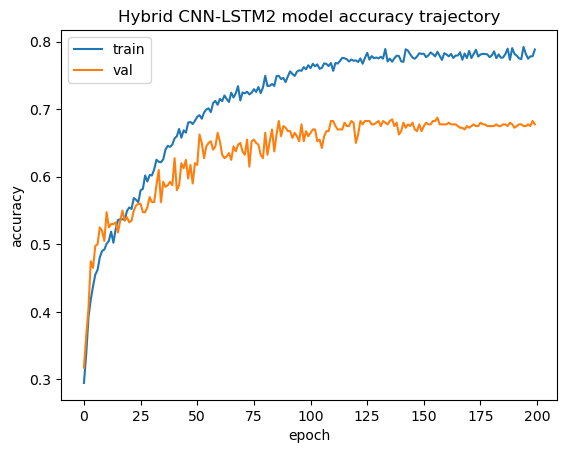

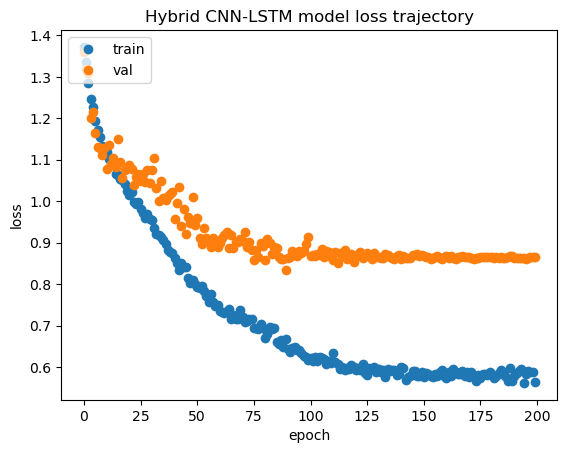

In [22]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['accuracy'])
plt.plot(hybrid_cnn_lstm_model_results.history['val_accuracy'])
plt.title('Hybrid CNN-LSTM2 model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# plt.savefig("Template/latex/accuracy.eps", format='eps')

# Plotting loss trajectory
plt.plot(hybrid_cnn_lstm_model_results.history['loss'],'o')
plt.plot(hybrid_cnn_lstm_model_results.history['val_loss'],'o')
plt.title('Hybrid CNN-LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()





In [23]:
## Testing the hybrid CNN-LSTM model

hybrid_cnn_lstm_score = hybrid_cnn_lstm_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:',hybrid_cnn_lstm_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.6884875893592834
